In [1]:
from rdkit import Chem
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data

# Run on CUDA

In [2]:
def format_pytorch_version(version):
    return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
    return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Data

In [3]:
df = pd.read_csv('data/train/train.csv')
smiles = pd.read_csv('data/train/smiles_train.csv')
data = df.join(smiles.set_index('MOFname'), on='MOFname')

data = data.dropna(subset=['Smiles'])
data = data.reset_index(drop=True)
print(data.isnull().sum())
print(data.shape)

MOFname                                             0
volume [A^3]                                        0
weight [u]                                          0
surface_area [m^2/g]                                0
void_fraction                                       0
void_volume [cm^3/g]                                0
functional_groups                                 323
metal_linker                                        0
organic_linker1                                     0
organic_linker2                                     0
topology                                            0
CO2/N2_selectivity                                  0
heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]    2087
CO2_working_capacity [mL/g]                         0
Smiles                                              0
dtype: int64
(68611, 15)


In [4]:
x_map = {
    'atomic_num':
    list(range(0, 119)),
    'chirality': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
    ],
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7)),
    'num_hs':
    list(range(0, 9)),
    'num_radical_electrons':
    list(range(0, 5)),
    'hybridization': [
        'UNSPECIFIED',
        'S',
        'SP',
        'SP2',
        'SP3',
        'SP3D',
        'SP3D2',
        'OTHER',
    ],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
}

e_map = {
    'bond_type': [
        'misc',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
    ],
    'stereo': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ],
    'is_conjugated': [False, True],
}

In [ ]:
data_list = []
data_dict = []
c = 1
for _, line in data.iterrows():
    mol = Chem.MolFromSmiles(line['Smiles'])
    
    if mol == None:
        continue
    
    # Create Node Features
    xs = []
    for atom in mol.GetAtoms():
        x = []
        x.append(x_map['atomic_num'].index(atom.GetAtomicNum()))
        x.append(x_map['chirality'].index(str(atom.GetChiralTag())))
        x.append(x_map['degree'].index(atom.GetTotalDegree()))
        x.append(x_map['formal_charge'].index(atom.GetFormalCharge()))
        x.append(x_map['num_hs'].index(atom.GetTotalNumHs()))
        x.append(x_map['num_radical_electrons'].index(atom.GetNumRadicalElectrons()))
        x.append(x_map['hybridization'].index(str(atom.GetHybridization())))
        x.append(x_map['is_aromatic'].index(atom.GetIsAromatic()))
        x.append(x_map['is_in_ring'].index(atom.IsInRing()))
        xs.append(x)
    x = torch.tensor(xs, dtype=torch.float).view(-1, 9)
    
    # Create Edge Features
    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map['bond_type'].index(str(bond.GetBondType())))
        e.append(e_map['stereo'].index(str(bond.GetStereo())))
        e.append(e_map['is_conjugated'].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

    # Sort indices.
    if edge_index.numel() > 0:
        perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

    y=torch.tensor([line['CO2/N2_selectivity'], line['CO2_working_capacity [mL/g]']], dtype=torch.float).view(1, -1)
    data_d = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,smiles=line['Smiles'])
    data_d.num_nodes = len(mol.GetAtoms())
    data_list.append(data_d)
    data_dict.append(line['MOFname'])
    
    if(c%10000==0):
        print('done:',c)
    c=c+1

In [ ]:
save_data_list = False
if save_data_list:
    pickle.dump(data_list, open('', 'wb'))

In [18]:
import pickle

data_list = pickle.load(open('data/train/graph_concat.pkl', 'rb'))

# Train Test Split

In [19]:
#torch.manual_seed(12345)
#dataset = dataset.shuffle()

#num_train=int(0.8*len(data_list))
#num_test=len(data_list)-num_train
import random
random.seed(10)

datasets = data_list

train_dataset, test_dataset = train_test_split(datasets, test_size=0.25, random_state = 1, shuffle=True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 49218
Number of test graphs: 16407


In [20]:
from torch_geometric.loader import DataLoader
import numpy as np

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
data_loader = DataLoader(datasets, batch_size=128, shuffle=True)

# GIN Model

In [21]:
from torch_geometric.nn import GINConv, GINEConv, global_add_pool
from torch.nn import Sequential, Linear, BatchNorm1d, ReLU

In [60]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, in_attr, dim, out_channels):
        super(Net, self).__init__()

        self.attr1 = Sequential(Linear(in_attr, in_channels), BatchNorm1d(in_channels), ReLU())
        self.conv1 = GINEConv(
            Sequential(Linear(in_channels, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr2 = Sequential(Linear(in_channels, dim), BatchNorm1d(dim), ReLU())
        self.conv2 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr3 = Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU())
        self.conv3 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr4 = Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU())
        self.conv4 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.attr5 = Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU())
        self.conv5 = GINEConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))

        self.lin1 = Linear(dim, dim)
        self.lin2 = Linear(dim, out_channels)

    def forward(self, x, edge_index, edge_attr, batch):
        edge_attr = self.attr1(edge_attr)
        x = self.conv1(x, edge_index, edge_attr)
        
        edge_attr = self.attr2(edge_attr)
        x = self.conv2(x, edge_index, edge_attr)
        
        edge_attr = self.attr3(edge_attr)
        x = self.conv3(x, edge_index, edge_attr)
        
        edge_attr = self.attr4(edge_attr)
        x = self.conv4(x, edge_index, edge_attr)
        
        edge_attr = self.attr5(edge_attr)
        x = self.conv5(x, edge_index, edge_attr)
        
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x
    
    def latent_space(self, x, edge_index, edge_attr, batch):
        edge_attr = self.attr1(edge_attr)
        x = self.conv1(x, edge_index, edge_attr)
        edge_attr = self.attr2(edge_attr)
        x = self.conv2(x, edge_index, edge_attr)
        edge_attr = self.attr3(edge_attr)
        x = self.conv3(x, edge_index, edge_attr)
        edge_attr = self.attr4(edge_attr)
        x = self.conv4(x, edge_index, edge_attr)
        edge_attr = self.attr5(edge_attr)
        x = self.conv5(x, edge_index, edge_attr)
        x = global_add_pool(x, batch)
        x = self.lin1(x).relu()
        return x

In [61]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.models import GIN
from torch.optim.lr_scheduler import ReduceLROnPlateau

num_node_features = 9
hidden_channels = 256
num_classes = 1
num_attr_features = 3

model = Net(in_channels=num_node_features, in_attr = num_attr_features, dim=hidden_channels,out_channels=num_classes).to(device)#GCN(hidden_channels=64,num_node_features=9,num_classes=1)
# model.load_state_dict(torch.load('model/best-model-GIN_Jack.pt')) # Load Model
print(model)

Net(
  (attr1): Sequential(
    (0): Linear(in_features=3, out_features=9, bias=True)
    (1): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv1): GINEConv(nn=Sequential(
    (0): Linear(in_features=9, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
  ))
  (attr2): Sequential(
    (0): Linear(in_features=9, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): GINEConv(nn=Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU()
  ))
  (attr3): Sequential(
    (0): Linear(in_f

# Train

In [62]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss()
scheduler = ReduceLROnPlateau(optimizer, 'min', verbose=True)

In [63]:
from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

def train(train_loader):
    model.train()
    c=0
    correct=0
    for data in train_loader:  # Iterate in batches over the training dataset.
        data.to(device)
        model.eval()
        model.zero_grad()
        
        with autocast():
            out = model(data.x, data.edge_index, data.edge_attr.float(), data.batch)  # Perform a single forward pass.
            loss = criterion(out, data.y)  # Compute the loss.
        
        scaler.scale(loss).backward()  # Derive gradients.
        scaler.step(optimizer)  # Update parameters based on gradients.
        scaler.update()  # Clear gradients.
        
#         print('done:',c+1,'batch','loss:',loss)
        c=c+1
        correct+=loss.cpu().detach().numpy()
        torch.cuda.empty_cache()
    return correct/c

def test(loader):
    model.eval()
    correct = 0
    c=0
    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr.float(), data.batch)  
        loss = criterion(out, data.y)  # Compute the loss.
        correct += loss.cpu().detach().numpy()  # Check against ground-truth labels.
        c=c+1
        torch.cuda.empty_cache()
        loss.cpu().detach().numpy()
        #print(correct)
    return correct / c  # Derive ratio of correct predictions.

In [64]:
print('start train')
train_loss = []
test_loss = []
epochs = 100

for epoch in range(epochs):
    train_acc = train(train_loader)
    test_acc = test(test_loader)
    train_loss.append(train_acc)
    test_loss.append(test_acc)
    scheduler.step(test_acc)
    print(f'Epoch: {epoch+1:03d}, Train MAE: {train_acc:.4f}, Test MAE: {test_acc:.4f}')
#     print(f'Epoch: {epoch+1:03d}, Train MAE: {train_acc:.4f}')

start train
Epoch: 001, Train MAE: 76.3365, Test MAE: 66.6888
Epoch: 002, Train MAE: 66.3372, Test MAE: 61.9767
Epoch: 003, Train MAE: 62.0007, Test MAE: 59.6642
Epoch: 004, Train MAE: 57.9824, Test MAE: 68.3640
Epoch: 005, Train MAE: 55.7188, Test MAE: 55.4410
Epoch: 006, Train MAE: 53.3640, Test MAE: 57.5857
Epoch: 007, Train MAE: 50.7031, Test MAE: 53.1708
Epoch: 008, Train MAE: 48.6675, Test MAE: 50.2072
Epoch: 009, Train MAE: 47.3208, Test MAE: 46.7236
Epoch: 010, Train MAE: 45.8460, Test MAE: 45.6808
Epoch: 011, Train MAE: 44.2956, Test MAE: 44.5174
Epoch: 012, Train MAE: 42.9926, Test MAE: 42.7273
Epoch: 013, Train MAE: 41.8747, Test MAE: 42.2794
Epoch: 014, Train MAE: 41.2404, Test MAE: 40.4569
Epoch: 015, Train MAE: 40.0456, Test MAE: 42.2885
Epoch: 016, Train MAE: 39.2568, Test MAE: 44.1023
Epoch: 017, Train MAE: 38.4739, Test MAE: 38.7467
Epoch: 018, Train MAE: 37.5935, Test MAE: 39.4234
Epoch: 019, Train MAE: 36.9610, Test MAE: 37.8216
Epoch: 020, Train MAE: 36.7492, Test M

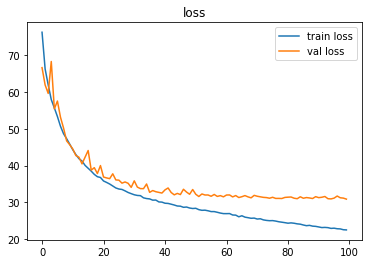

In [65]:
import matplotlib.pyplot as plt

plt.title('loss')
plt.plot(np.arange(epochs), train_loss, label='train loss')
plt.plot(np.arange(epochs), test_loss, label='val loss')
plt.legend()
plt.show()

In [47]:
save = False
if save:
    torch.save(model.state_dict(), "model/best_GINE.pt")

# Inference

In [22]:
data_list = pickle.load(open('data/test/graph_test.pkl', 'rb'))

In [23]:
data_loader = DataLoader(data_list, batch_size=128, shuffle=False)

In [24]:
latent_space_list = []

for data in data_loader:  # Iterate in batches over the training dataset.
    data.to(device)
    
    latent_space = model.latent_space(data.x, data.edge_index, data.edge_attr.float(), data.batch).cpu().detach().numpy()
    latent_space_list.append(latent_space)
    
    torch.cuda.empty_cache()
    
latent_space_list = np.concatenate(latent_space_list, axis=0)

In [25]:
latent_space_list.shape

(16237, 256)

In [26]:
pickle.dump(latent_space_list, open('data/test/latent_space_GINE.pkl', 'wb'))